# Read libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from copy import copy, deepcopy
from pathlib import Path
from sys import path

path.append( str(Path.cwd().parent) )

In [2]:
import json
import re

import matplotlib.pyplot as plt
import pandas as pd

from collections import Counter
from matplotlib.gridspec import GridSpec
from numpy import arange, array, exp, isnan, log
from statsmodels.formula.api import ols
from string import punctuation, whitespace


from Project_libraries.my_stats import ( half_frame, place_commas )
from Project_libraries.pubmed import ( get_time_series, plot_time_series,
                                       classify_articles, 
                                       count_articles_by_journal,
                                       get_articles_by_publisher, 
                                     )

# Load journal catalogue

In [3]:
catalogue_file = Path.cwd() / 'Project_libraries' / 'journal_catalogue.json'

with open(catalogue_file, 'r', encoding = 'utf-8') as file_in:
    catalogue = json.load(file_in)

In [4]:
#Check number of journals without information
#
count = 0
for journal in catalogue:
    if catalogue[journal]['publisher'] is None:
        count += 1
        
        
print(f"There are {len(catalogue)} items in the Journal Catalogue.\n\n"
      f"We lack publisher information for {count} journals.")



There are 5615 items in the Journal Catalogue.

We lack publisher information for 1463 journals.


In [30]:
publisher_list = []
for journal in catalogue:
    if catalogue[journal]:
        publisher = catalogue[journal]['publisher'] 
        if publisher not in publisher_list:
            publisher_list.append(publisher )

print(publisher_list)
publisher_list.remove(None)


['Springer Nature', 'IMR Press', 'British Medical Association', None, 'Elsevier', 'Wiley', 'IOS Press', 'Wolters Kluwer', 'American Association for Cancer Research', 'Oxford University Press', 'American Medical Informatics Association', 'Future Science', 'American Medical Association', 'Taylor & Francis', 'Cold Spring Harbor Laboratory Press', 'Mary Ann Liebert', 'PLoS', 'Spandidos', 'American Society of Clinical Oncology', 'De Gruyter', 'Hindawi', 'Canadian Medical Association', 'Cambridge University Press', 'Karger', 'MDPI', 'American College of Physicians', 'Bentham', 'AAAS', 'National Academy of Sciences', 'Zhonghua yi xue hui', 'Lancet', 'Sage', 'American Medical Pub', 'Slovak Academic Press', 'Cell Press', 'Impact Journals', 'CRC Press', 'International Institute of Anticancer Research', 'Biochemical Society', 'Chinese Medical Association', 'Future Science Group', 'American Public Health Association', 'American Chemical Society', 'Meditsina', 'Royal Australian College of General P

# Import articles

In [5]:
cwd = Path.cwd()
aux = cwd.glob('Case_*')

cases = []
for case in aux:
    cases.append( case.parts[-1] )
    
cases.sort()

for i in range(len(cases)):
    print(f"{i:>2} -- {cases[i]}")

 0 -- Case_brain_cancer_stem_cells
 1 -- Case_brca2
 2 -- Case_chest_imaging_pneumonia
 3 -- Case_deep_learning_tumor
 4 -- Case_graphene_sensors
 5 -- Case_green_synthesis_np
 6 -- Case_green_synthesis_silver_np
 7 -- Case_prions
 8 -- Case_rnai_cancer
 9 -- Case_skin_wound_healing
10 -- Case_statins_cancer


In [6]:
my_parameters = [{'folder': cwd / cases[0], 'year1': 1992, 'year2': 2024, 'min_size': 100, 'add_fit': True},
                 {'folder': cwd / cases[1], 'year1': 1994, 'year2': 2024, 'min_size': 150, 'add_fit': True},
                 {'folder': cwd / cases[2], 'year1': 2008, 'year2': 2024, 'min_size': 100, 'add_fit': False},
                 {'folder': cwd / cases[3], 'year1': 2012, 'year2': 2024, 'min_size': 100, 'add_fit': False},
                 {'folder': cwd / cases[4], 'year1': 2004, 'year2': 2024, 'min_size': 60, 'add_fit': False},
                 {'folder': cwd / cases[5], 'year1': 2004, 'year2': 2024, 'min_size': 90, 'add_fit': False},
                 {'folder': cwd / cases[6], 'year1': 2004, 'year2': 2024, 'min_size': 60, 'add_fit': False},
                 {'folder': cwd / cases[7], 'year1': 1984, 'year2': 2024, 'min_size': 400, 'add_fit': True},
                 {'folder': cwd / cases[8], 'year1': 2000, 'year2': 2024, 'min_size': 70, 'add_fit': False},
                 {'folder': cwd / cases[9], 'year1': 2000, 'year2': 2024, 'min_size': 75, 'add_fit': True},
                 {'folder': cwd / cases[10], 'year1': 1992, 'year2': 2024, 'min_size': 90, 'add_fit': False},
                ]

In [65]:
case = my_parameters[9]
print(f"We will be processing the data in folder '{case['folder'].parts[-1]}'.\n")

case_folder = case['folder']

articles_file = case_folder / 'articles_clean.json'
png_file = case_folder / 'time_series.png'



We will be processing the data in folder 'Case_skin_wound_healing'.



In [66]:
with open(articles_file, 'r', encoding = 'utf-8') as f_json:
    articles = json.load(f_json)
    
print( f"There are {place_commas(len(articles))} articles in the "
       f"'{case['folder'].parts[-1]}' collection.\n" )


There are 2,287 articles in the 'Case_skin_wound_healing' collection.



In [67]:
print( f"We are verifying publisher information for "
       f"{place_commas(len(articles))} articles.\n" )

no_info = []
for i, article in enumerate( articles ):
    journal = article['journal']
    
    journal_info = catalogue[journal]
    
    # We lack info for some journals
    #
    if journal_info['publisher'] is None:
        no_info.append(i)
        for key in ['publisher', 'start_date', 'mesh']:
            article[key] = None

        continue
    
    for key in ['publisher', 'start_date', 'mesh']:
        if key not in journal_info.keys():
            article[key] = None
        else:
            article[key] = journal_info[key]
        
    
print(f"Finished processing all articles.\n\n"
      f"We lack publisher information for {place_commas(len(no_info))} articles.")



We are verifying publisher information for 2,287 articles.

Finished processing all articles.

We lack publisher information for 212 articles.


## Calculate breakdown by publisher

In [68]:
publishers = []
for article in articles:
    if 'publisher' in article.keys():
        publishers.append( article['publisher'] )
    
counter = Counter(publishers)

counter.most_common(20)

[('Elsevier', 509),
 ('Wiley', 314),
 ('Springer Nature', 251),
 ('MDPI', 212),
 (None, 212),
 ('Frontiers', 78),
 ('American Chemical Society', 75),
 ('Taylor & Francis', 69),
 ('Mary Ann Liebert', 58),
 ('Oxford University Press', 56),
 ('Hindawi', 49),
 ('PLoS', 43),
 ('Sage', 33),
 ('Royal Society of Chemistry', 32),
 ('Spandidos', 27),
 ('Wolters Kluwer', 26),
 ('Karger', 18),
 ('FASEB', 18),
 ('IOP Publishing', 18),
 ('Cell Press', 16)]

In [69]:
count_articles_by_journal(get_articles_by_publisher(articles, None), 30)

[('Acta Cir Bras', 10),
 ('Fa Yi Xue Za Zhi', 9),
 ('Ann Plast Surg', 7),
 ('Zhongguo Xiu Fu Chong Jian Wai Ke Za Zhi', 6),
 ('Wounds', 6),
 ('J Cell Biol', 5),
 ('Biofizika', 5),
 ('Sheng Wu Yi Xue Gong Cheng Xue Za Zhi', 5),
 ('Radiat Res', 5),
 ('Histol Histopathol', 5),
 ('Diabetes', 5),
 ('Iran J Basic Med Sci', 3),
 ('J Wound Care', 3),
 ('Eur J Dermatol', 3),
 ('Antioxidants (Basel)', 3),
 ('J Lasers Med Sci', 3),
 ('J Clin Invest', 3),
 ('Int J Biol Sci', 3),
 ('Braz J Med Biol Res', 3),
 ('Int J Bioprint', 3),
 ('J Vis Exp', 3),
 ('Endocrinology', 3),
 ('Sheng Li Xue Bao', 2),
 ('Med Sci Monit', 2),
 ('Zhong Yao Cai', 2),
 ('Folia Biol (Praha)', 2),
 ('J Huazhong Univ Sci Technolog Med Sci', 2),
 ('Arq Bras Cir Dig', 2),
 ('Vet World', 2),
 ('Int J Med Sci', 2)]

# Analyze trends relating to review articles

In [70]:
year0 = case['year1']
year1 = case['year2']

pattern1 = 'review'
pattern2 = 'reviewed'

# Full set 
#
output = classify_articles( articles, 'FULL' )
no_abstract_all, retracted_all, erratum_all, commented_all = output

# Review articles set
#
review_articles = []
for article in articles:
    if article['abstract']:
        if ( pattern1 in article['abstract'].lower() 
             or pattern2 in article['abstract'].lower() ):
            review_articles.append( article )

output = classify_articles( review_articles, 'REVIEW' )
no_abstract_review, retracted_review, erratum_review, commented_review = output


# No review articles set
#
no_review_articles = []
for article in articles:
    if article['abstract']:
        if not ( pattern1 in article['abstract'].lower() 
                 or pattern2 in article['abstract'].lower() ):
            no_review_articles.append( article )

output = classify_articles( no_review_articles, 'NO REVIEW' )
no_abstract_norev, retracted_norev, erratum_norev, commented_norev = output


There are 2287 articles in the 'FULL' set.
16 have no abstract; 
7 have been retracted; 
41 have had errata published; and 
5 have had comments written about them.


There are 283 articles in the 'REVIEW' set.
0 have no abstract; 
0 have been retracted; 
1 have had errata published; and 
1 have had comments written about them.


There are 1988 articles in the 'NO REVIEW' set.
0 have no abstract; 
7 have been retracted; 
40 have had errata published; and 
4 have had comments written about them.




## Create dataframe with time series 

In [71]:
df_time_series = pd.DataFrame( {'Year': array(range(year0, year1)), 
                                'Full Set Papers': get_time_series(pd.DataFrame(articles), year0, year1),
                                'FS Retracted': get_time_series(pd.DataFrame(retracted_all), year0, year1), 
                                'FS Errata': get_time_series(pd.DataFrame(erratum_all), year0, year1),
                                'FS Comments': get_time_series(pd.DataFrame(commented_all), year0, year1),
                                'Review Papers': get_time_series(pd.DataFrame(review_articles), year0, year1),
                                'Rev Retracted': get_time_series(pd.DataFrame(retracted_review), year0, year1), 
                                'Rev Errata': get_time_series(pd.DataFrame(erratum_review), year0, year1),
                                'Rev Comments': get_time_series(pd.DataFrame(commented_review), year0, year1),
                                'No Review Papers': get_time_series(pd.DataFrame(no_review_articles), year0, year1),
                                'NoRev Retracted': get_time_series(pd.DataFrame(retracted_norev), year0, year1), 
                                'NoRev Errata': get_time_series(pd.DataFrame(erratum_norev), year0, year1),
                                'NoRev Comments': get_time_series(pd.DataFrame(commented_norev), year0, year1),
                               } )

df_time_series



,Year,Full Set Papers,FS Retracted,FS Errata,FS Comments,Review Papers,Rev Retracted,Rev Errata,Rev Comments,No Review Papers,NoRev Retracted,NoRev Errata,NoRev Comments
0,2000,9,0,0,0,0,NaN,0,0,9,0,0,0
1,2001,20,0,0,0,2,NaN,0,0,18,0,0,0
2,2002,14,0,1,0,0,NaN,0,0,14,0,1,0
3,2003,17,0,2,0,1,NaN,0,0,16,0,2,0
4,2004,32,0,0,0,4,NaN,0,0,28,0,0,0
5,2005,31,0,0,0,0,NaN,0,0,31,0,0,0
6,2006,27,0,2,0,0,NaN,0,0,26,0,2,0
7,2007,35,0,1,0,4,NaN,0,0,31,0,1,0
8,2008,34,0,1,0,5,NaN,0,0,29,0,1,0
9,2009,38,0,2,0,2,NaN,0,0,36,0,2,0


## Calculate ratios

In [72]:
key = 'Review Papers'
column = f"{key}_ratio"
df_time_series[column] = df_time_series[key] / df_time_series['Full Set Papers']
    
for key in [ 'NoRev Retracted', 'NoRev Errata', 'NoRev Comments' ]:
    column = f"{key}_ratio"
    df_time_series[column] = df_time_series[key] / df_time_series['No Review Papers']


## Plot data

                            OLS Regression Results                            
Dep. Variable:              ln_Papers   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     611.8
Date:                Tue, 02 Apr 2024   Prob (F-statistic):           1.51e-17
Time:                        10:24:16   Log-Likelihood:                 6.7846
No. Observations:                  24   AIC:                            -9.569
Df Residuals:                      22   BIC:                            -7.213
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -275.3847     11.300    -24.371      0.0

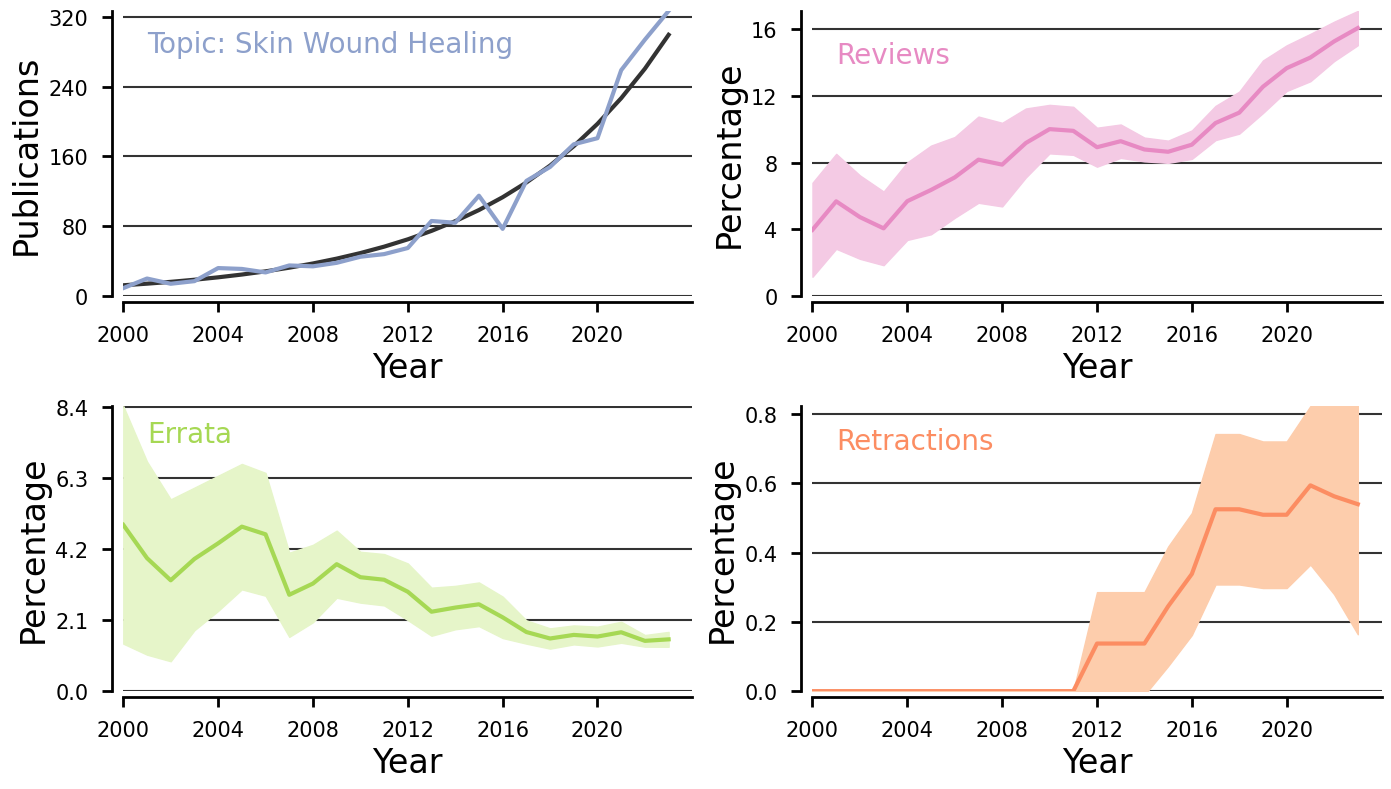

In [73]:
add_fit = case['add_fit']
colors = { 'Papers': '#8da0cb', 'Retracted': '#fc8d62', 'Reviews': '#e78ac3',
           'Errata': '#a6d854', 'Comments': '#66c2a5', }

colors_b = { 'Papers': '#cbd5e8', 'Retracted': '#fdcdac', 'Reviews': '#f4cae4',
             'Errata': '#e6f5c9', 'Comments': '#b3e2cd', }

folder = str(case_folder)[77:]

fig = plt.figure( figsize = (14, 8) )
ax = []

ax.append(fig.add_subplot(221))
plot_time_series( ax[-1], df_time_series, 'Full Set Papers', 1, 
                         folder.replace('_', ' '), colors['Papers'], 
                         colors_b['Papers'] )

# Add exponential fit
df_time_series['ln_Papers'] = log(df_time_series['Full Set Papers'])
model = ols( formula = 'ln_Papers ~ Year', data = df_time_series)
results = model.fit()
print(results.summary())
if add_fit:
    ax[-1].plot( df_time_series.Year, 
                 exp(results.params.Intercept + results.params.Year * df_time_series.Year),
                 lw = 3, color = '0.2', zorder = -3)

ax.append(fig.add_subplot(222))
plot_time_series( ax[-1], df_time_series, 'Review Papers_ratio', 7, 
                        'Reviews', colors['Reviews'], 
                        colors_b['Reviews'] )

ax.append(fig.add_subplot(224))
plot_time_series( ax[-1], df_time_series, 'NoRev Retracted_ratio', 7, 
                        'Retractions', colors['Retracted'], 
                        colors_b['Retracted'] )

ax.append(fig.add_subplot(223))
# plot_time_series( ax[-1], df_time_series, 'NoRev Comments_ratio', 5, 
#                          'Comments', colors['Comments'], 
#                         colors_b['Comments'] )

plot_time_series( ax[-1], df_time_series, 'NoRev Errata_ratio', 7, 
                        'Errata', colors['Errata'], 
                        colors_b['Errata'] )

plt.tight_layout()

plt.savefig(png_file)

# Analyze trends by journal


There are 62 articles in the set for Int J Mol Sci
There are 62 articles in the 'FULL' set.
0 have no abstract; 
0 have been retracted; 
1 have had errata published; and 
0 have had comments written about them.


There are 16 articles in the 'REVIEW' set.
0 have no abstract; 
0 have been retracted; 
0 have had errata published; and 
0 have had comments written about them.


There are 46 articles in the 'NO REVIEW' set.
0 have no abstract; 
0 have been retracted; 
1 have had errata published; and 
0 have had comments written about them.



There are 60 articles in the set for J Invest Dermatol
There are 60 articles in the 'FULL' set.
2 have no abstract; 
0 have been retracted; 
2 have had errata published; and 
0 have had comments written about them.


There are 1 articles in the 'REVIEW' set.
0 have no abstract; 
0 have been retracted; 
0 have had errata published; and 
0 have had comments written about them.


There are 57 articles in the 'NO REVIEW' set.
0 have no abstract; 
0 have 

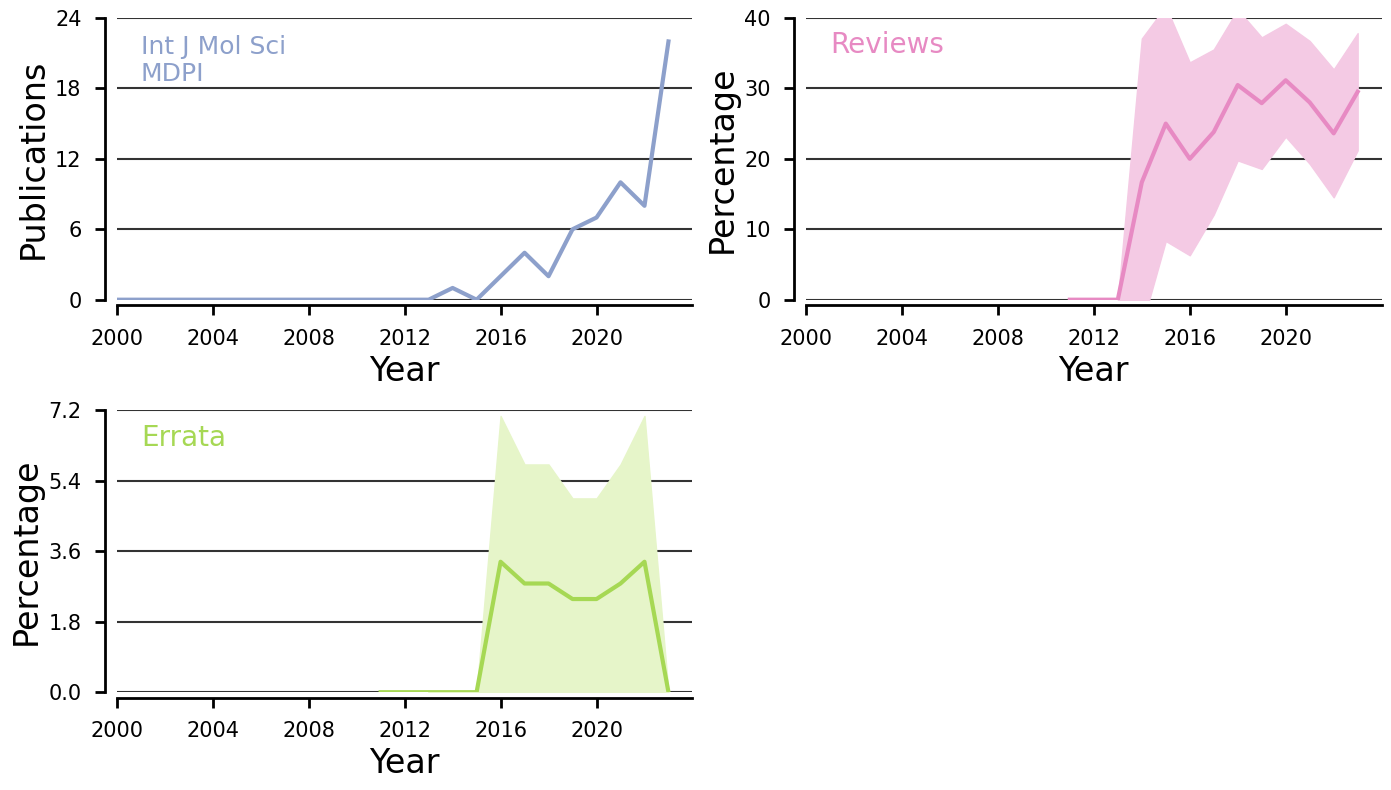

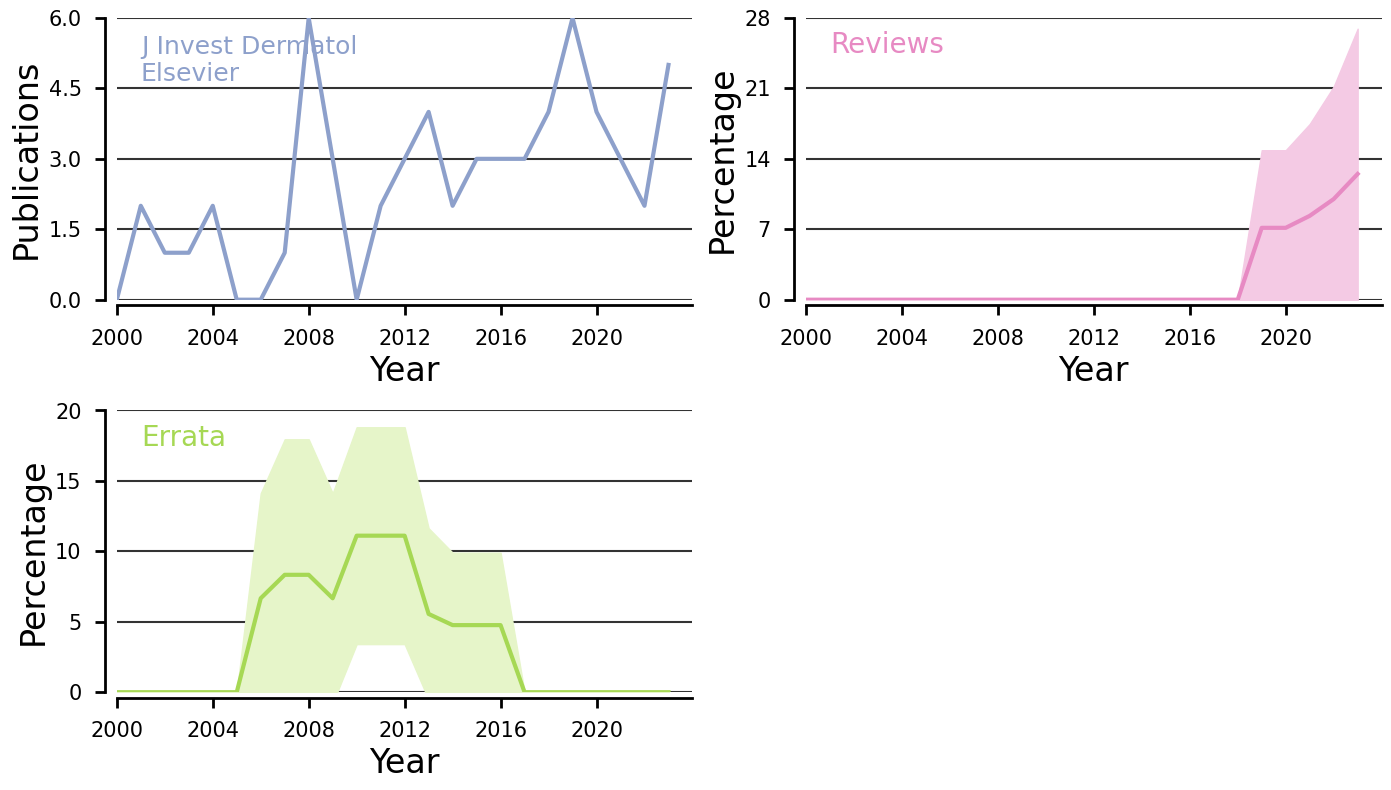

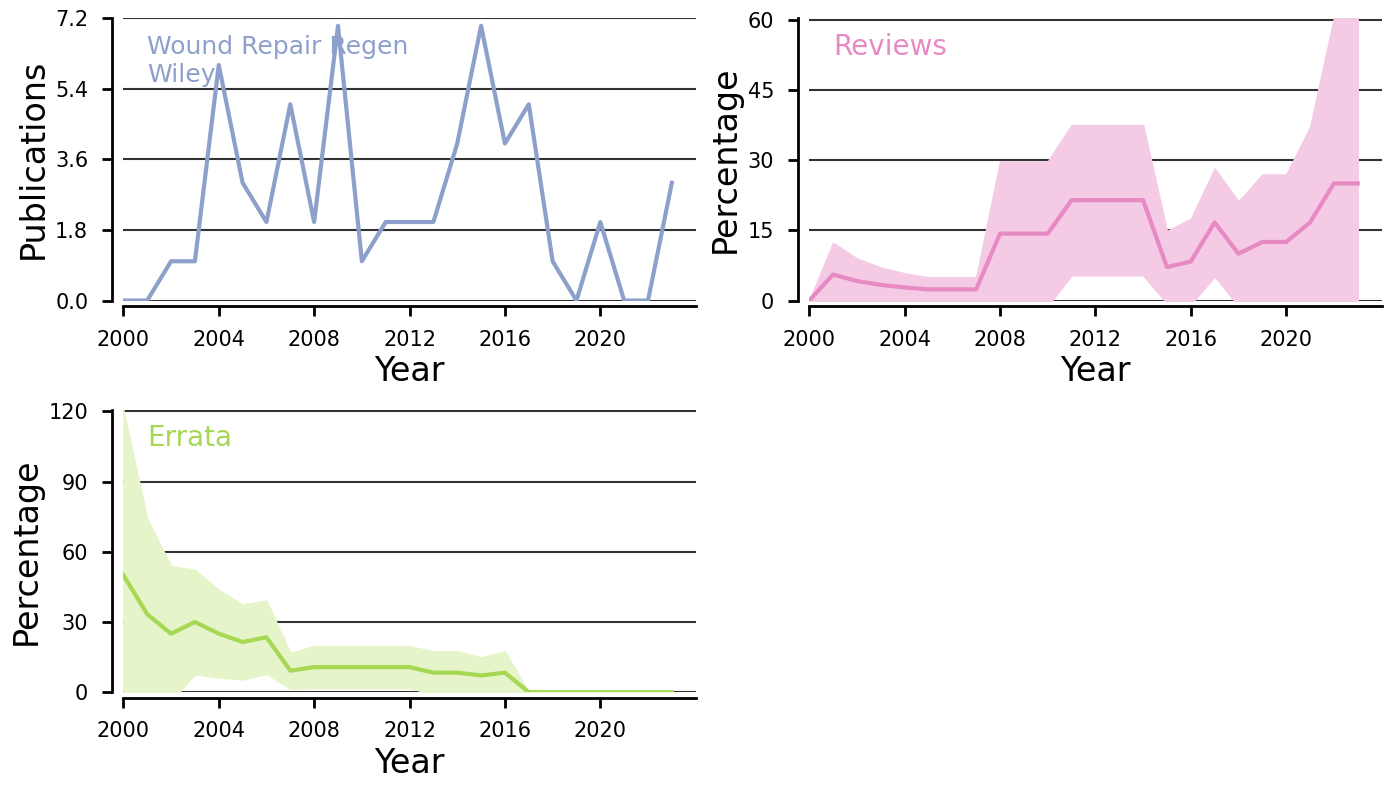

In [74]:
min_size = case['min_size']

for journal in catalogue: 
    target_articles = []
    for article in articles:
        if article['journal'] == journal:
            target_articles.append( article )    

    if len(target_articles) < min_size * 0.8:
        continue
        
    print(f"\nThere are {len(target_articles)} articles in the set for "
          f"{journal}")

    pattern1 = 'review'
    pattern2 = 'reviewed'

    # Full set 
    #
    output = classify_articles( target_articles, 'FULL' )
    no_abstract_all, retracted_all, erratum_all, commented_all = output

    # Review articles set
    #
    review_articles = []
    for article in target_articles:
        if article['abstract']:
            if ( pattern1 in article['abstract'].lower() 
                 or pattern2 in article['abstract'].lower() ):
                review_articles.append( article )

    output = classify_articles( review_articles, 'REVIEW' )
    no_abstract_review, retracted_review, erratum_review, commented_review = output

    # No review articles set
    #
    no_review_articles = []
    for article in target_articles:
        if article['abstract']:
            if not ( pattern1 in article['abstract'].lower() 
                     or pattern2 in article['abstract'].lower() ):
                no_review_articles.append( article )

    output = classify_articles( no_review_articles, 'NO REVIEW' )
    no_abstract_norev, retracted_norev, erratum_norev, commented_norev = output

    df_target = pd.DataFrame( {'Year': array(range(year0, year1)), 
                                'Full Set Papers': get_time_series(pd.DataFrame(target_articles), year0, year1),
                                'FS Retracted': get_time_series(pd.DataFrame(retracted_all), year0, year1), 
                                'FS Errata': get_time_series(pd.DataFrame(erratum_all), year0, year1),
                                'FS Comments': get_time_series(pd.DataFrame(commented_all), year0, year1),
                                'Review Papers': get_time_series(pd.DataFrame(review_articles), year0, year1),
                                'Rev Retracted': get_time_series(pd.DataFrame(retracted_review), year0, year1), 
                                'Rev Errata': get_time_series(pd.DataFrame(erratum_review), year0, year1),
                                'Rev Comments': get_time_series(pd.DataFrame(commented_review), year0, year1),
                                'No Review Papers': get_time_series(pd.DataFrame(no_review_articles), year0, year1),
                                'NoRev Retracted': get_time_series(pd.DataFrame(retracted_norev), year0, year1), 
                                'NoRev Errata': get_time_series(pd.DataFrame(erratum_norev), year0, year1),
                                'NoRev Comments': get_time_series(pd.DataFrame(commented_norev), year0, year1),
                               } )

    key = 'Review Papers'
    column = f"{key}_ratio"
    df_target[column] = df_target[key] / df_target['Full Set Papers']

    for key in [ 'NoRev Retracted', 'NoRev Errata', 'NoRev Comments' ]:
        column = f"{key}_ratio"
        df_target[column] = df_target[key] / df_target['No Review Papers']

    colors = { 'Papers': '#8da0cb', 'Retracted': '#fc8d62', 'Reviews': '#e78ac3',
               'Errata': '#a6d854', 'Comments': '#66c2a5', }

    colors_b = { 'Papers': '#cbd5e8', 'Retracted': '#fdcdac', 'Reviews': '#f4cae4',
                 'Errata': '#e6f5c9', 'Comments': '#b3e2cd', }

    fig = plt.figure( figsize = (14, 8) )
    ax = []


    ax.append(fig.add_subplot(221))
    if catalogue[journal] and catalogue[journal]['publisher']:
        my_label = '\n'.join([journal, catalogue[journal]['publisher']])
    else:
        my_label = journal
    plot_time_series( ax[-1], df_target, 'Full Set Papers', 1, 
                      my_label,  
                      colors['Papers'], colors_b['Papers'] )

    if df_target['Review Papers_ratio'].count() > 0:
        ax.append(fig.add_subplot(222))
        plot_time_series( ax[-1], df_target, 'Review Papers_ratio', 7, 
                          'Reviews', colors['Reviews'], 
                          colors_b['Reviews'] )

    if df_target['NoRev Retracted_ratio'].count() > 0:
        ax.append(fig.add_subplot(224))
        plot_time_series( ax[-1], df_target, 'NoRev Retracted_ratio', 7, 
                          'Retractions', colors['Retracted'], 
                          colors_b['Retracted'] )

    if df_target['NoRev Errata_ratio'].count() > 0:
        ax.append(fig.add_subplot(223))
        plot_time_series( ax[-1], df_target, 'NoRev Errata_ratio', 7, 
                          'Errata', colors['Errata'], 
                          colors_b['Errata'] )

    plt.tight_layout()
    plt.savefig(Path.cwd() / folder / 'Journals' / f"time_series_{journal}.png")

# Analyze trends by publisher



There are 9 articles in the set for AAAS

There are 2 articles in the set for AIP Publ

There are 7 articles in the set for AME Publishing

There are 0 articles in the set for Academia Brasileira De Ciencias

There are 0 articles in the set for American Academy of Family Physicians

There are 1 articles in the set for American Association for Cancer Research

There are 1 articles in the set for American Association for Laboratory Animal Science

There are 9 articles in the set for American Association of Immunologists

There are 75 articles in the set for American Chemical Society
There are 75 articles in the 'FULL' set.
0 have no abstract; 
1 have been retracted; 
0 have had errata published; and 
0 have had comments written about them.


There are 5 articles in the 'REVIEW' set.
0 have no abstract; 
0 have been retracted; 
0 have had errata published; and 
0 have had comments written about them.


There are 70 articles in the 'NO REVIEW' set.
0 have no abstract; 
1 have been retract

/Users/amaral/anaconda3/envs/new_base/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



There are 18 articles in the set for FASEB

There are 1 articles in the set for Federation of European Biochemical Societies

There are 78 articles in the set for Frontiers
There are 78 articles in the 'FULL' set.
0 have no abstract; 
0 have been retracted; 
3 have had errata published; and 
0 have had comments written about them.


There are 25 articles in the 'REVIEW' set.
0 have no abstract; 
0 have been retracted; 
0 have had errata published; and 
0 have had comments written about them.


There are 53 articles in the 'NO REVIEW' set.
0 have no abstract; 
0 have been retracted; 
3 have had errata published; and 
0 have had comments written about them.



There are 5 articles in the set for Future Science

There are 3 articles in the set for Future Science Group

There are 49 articles in the set for Hindawi

There are 0 articles in the set for IEEE

There are 0 articles in the set for IMR Press

There are 18 articles in the set for IOP Publishing

There are 0 articles in the set fo

/Users/amaral/anaconda3/envs/new_base/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/amaral/anaconda3/envs/new_base/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)



There are 58 articles in the set for Mary Ann Liebert

There are 2 articles in the set for Meditsina

There are 5 articles in the set for National Academy of Sciences

There are 2 articles in the set for National Research Council of Canada

There are 0 articles in the set for OMICS

There are 56 articles in the set for Oxford University Press

There are 43 articles in the set for PLoS

There are 3 articles in the set for Pharmaceutical Society of Japan

There are 0 articles in the set for Pharmaceutical Society of Korea

There are 1 articles in the set for Polski Towarzystwo Farmaceutyczne

There are 0 articles in the set for Princeton University Press

There are 0 articles in the set for Royal Australian College of General Practitioners

There are 0 articles in the set for Royal College of Surgeons of England

There are 0 articles in the set for Royal Society

There are 32 articles in the set for Royal Society of Chemistry

There are 4 articles in the set for SPIE

There are 33 artic

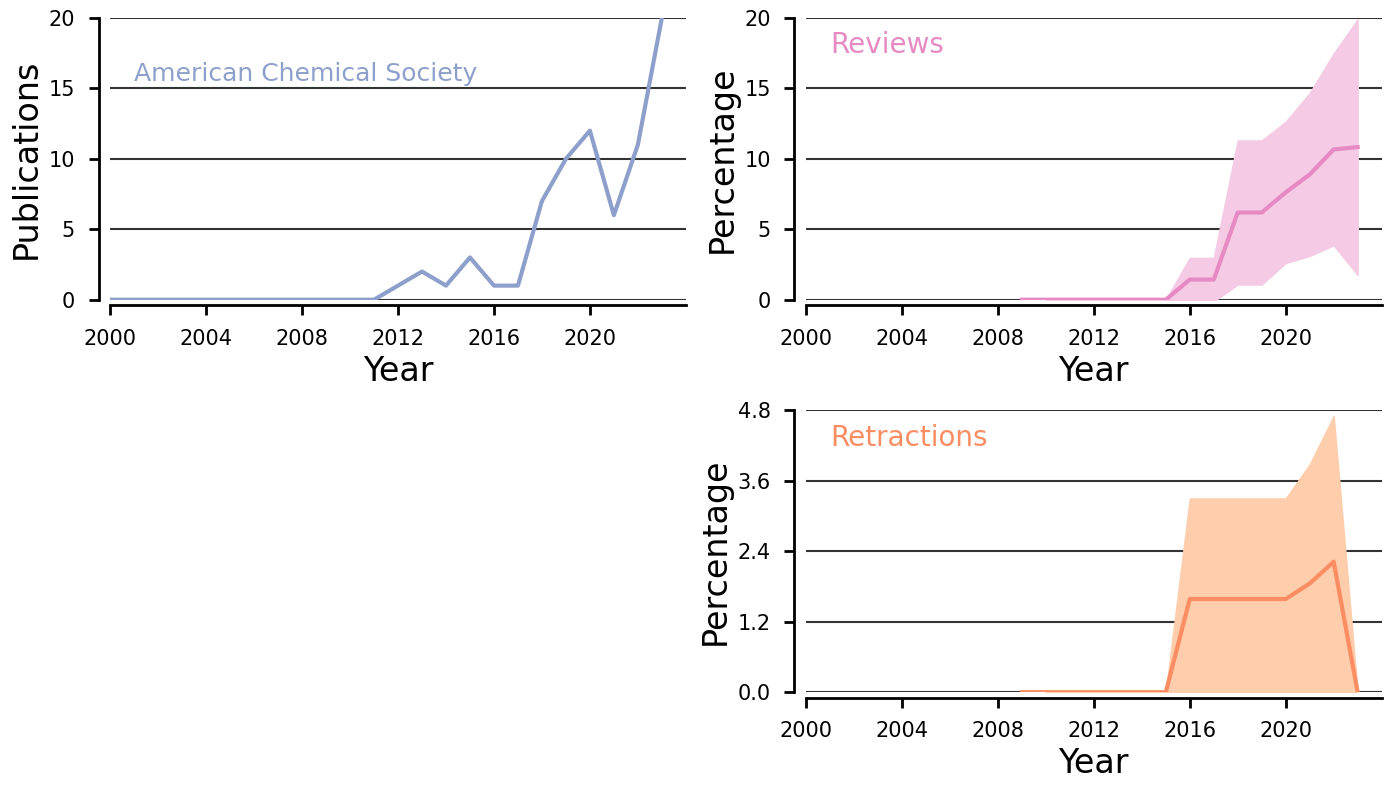

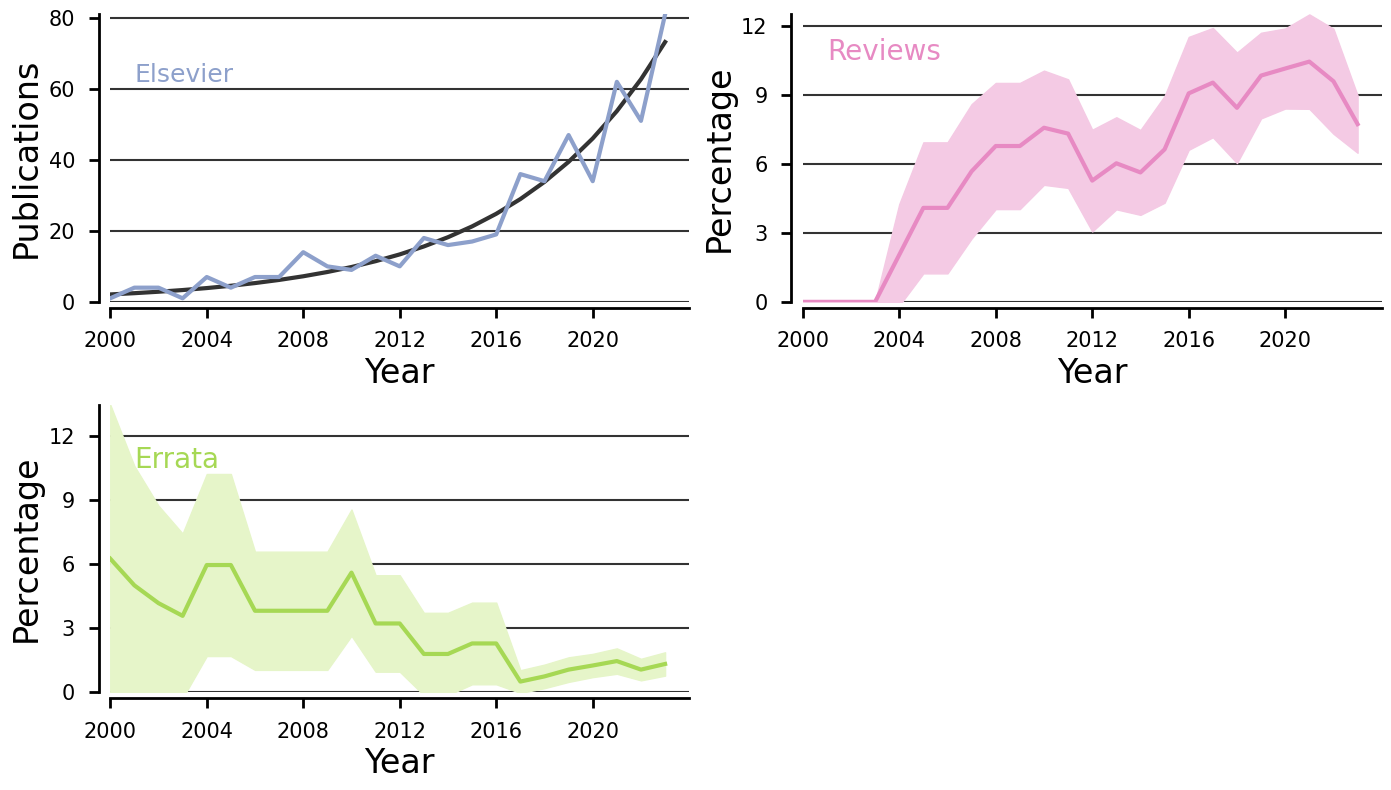

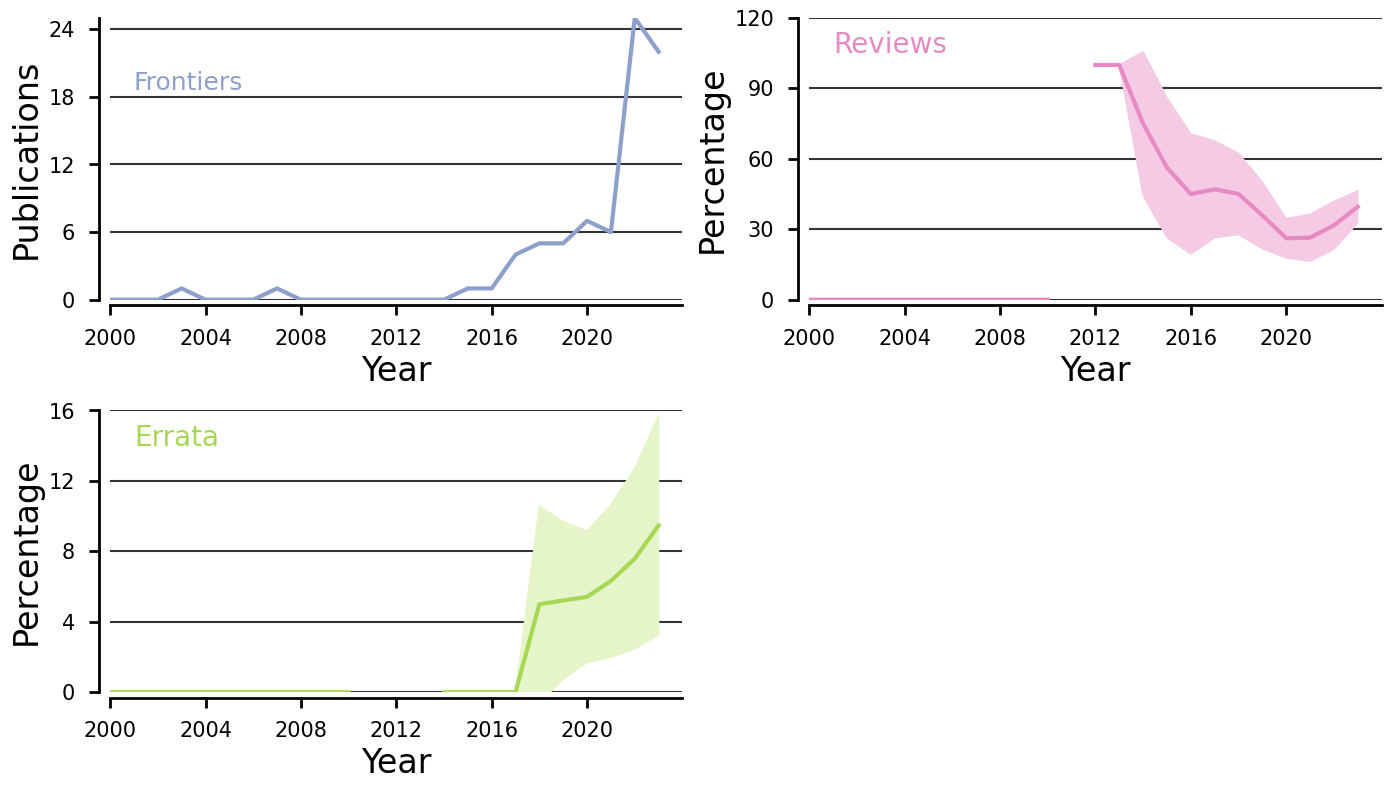

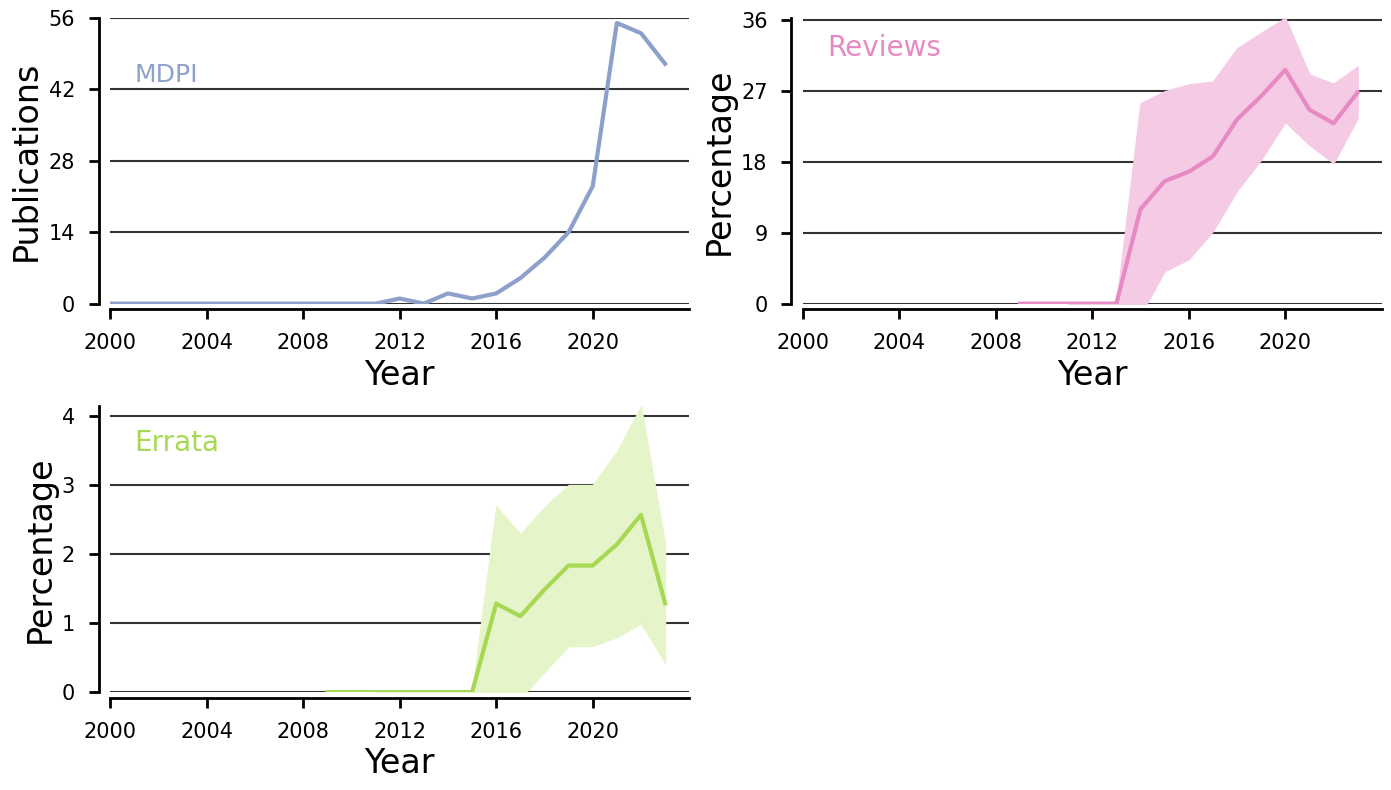

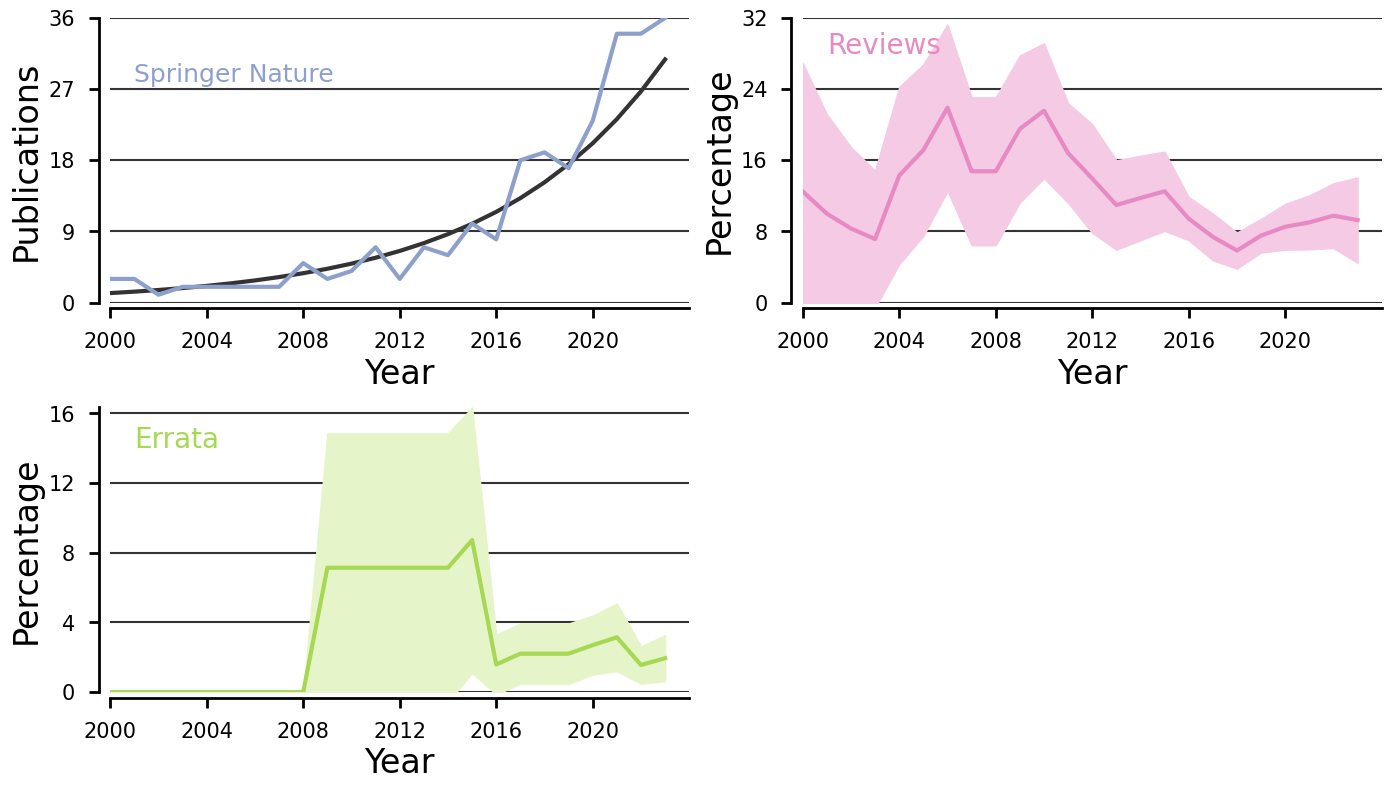

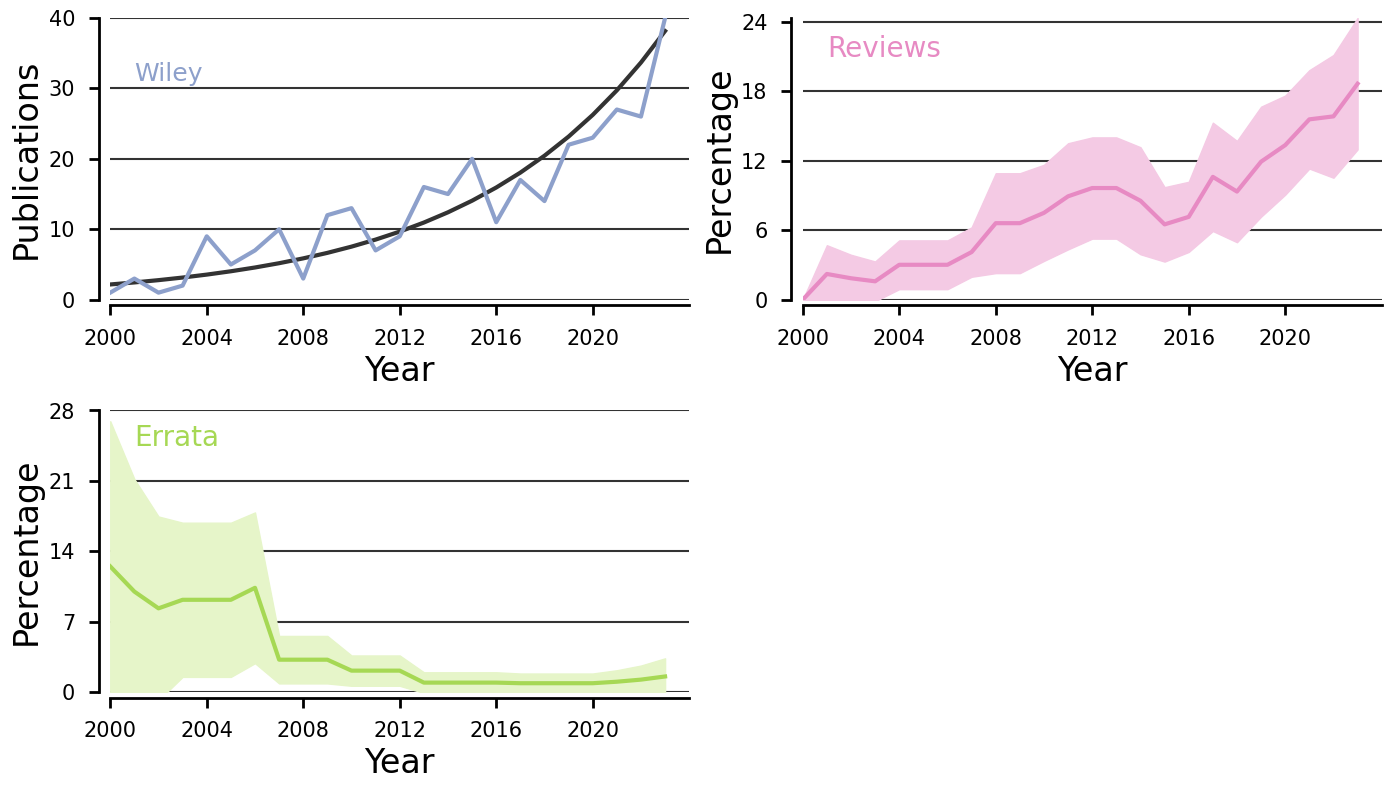

In [75]:
for publisher in sorted( publisher_list ): 
    target_articles = []
    for article in articles:
        if article['publisher']:
            if article['publisher'] == publisher:
                target_articles.append( article )

    print(f"\nThere are {len(target_articles)} articles in the set for "
          f"{publisher}")

    if len(target_articles) < min_size:
        continue
        
    pattern1 = 'review'
    pattern2 = 'reviewed'

    # Full set 
    #
    output = classify_articles( target_articles, 'FULL' )
    no_abstract_all, retracted_all, erratum_all, commented_all = output

    # Review articles set
    #
    review_articles = []
    for article in target_articles:
        if article['abstract']:
            if ( pattern1 in article['abstract'].lower() 
                 or pattern2 in article['abstract'].lower() ):
                review_articles.append( article )

    output = classify_articles( review_articles, 'REVIEW' )
    no_abstract_review, retracted_review, erratum_review, commented_review = output

    # No review articles set
    #
    no_review_articles = []
    for article in target_articles:
        if article['abstract']:
            if not ( pattern1 in article['abstract'].lower() 
                     or pattern2 in article['abstract'].lower() ):
                no_review_articles.append( article )

    output = classify_articles( no_review_articles, 'NO REVIEW' )
    no_abstract_norev, retracted_norev, erratum_norev, commented_norev = output

    df_target = pd.DataFrame( {'Year': array(range(year0, year1)), 
                                'Full Set Papers': get_time_series(pd.DataFrame(target_articles), year0, year1),
                                'FS Retracted': get_time_series(pd.DataFrame(retracted_all), year0, year1), 
                                'FS Errata': get_time_series(pd.DataFrame(erratum_all), year0, year1),
                                'FS Comments': get_time_series(pd.DataFrame(commented_all), year0, year1),
                                'Review Papers': get_time_series(pd.DataFrame(review_articles), year0, year1),
                                'Rev Retracted': get_time_series(pd.DataFrame(retracted_review), year0, year1), 
                                'Rev Errata': get_time_series(pd.DataFrame(erratum_review), year0, year1),
                                'Rev Comments': get_time_series(pd.DataFrame(commented_review), year0, year1),
                                'No Review Papers': get_time_series(pd.DataFrame(no_review_articles), year0, year1),
                                'NoRev Retracted': get_time_series(pd.DataFrame(retracted_norev), year0, year1), 
                                'NoRev Errata': get_time_series(pd.DataFrame(erratum_norev), year0, year1),
                                'NoRev Comments': get_time_series(pd.DataFrame(commented_norev), year0, year1),
                               } )

    key = 'Review Papers'
    column = f"{key}_ratio"
    df_target[column] = df_target[key] / df_target['Full Set Papers']

    for key in [ 'NoRev Retracted', 'NoRev Errata', 'NoRev Comments' ]:
        column = f"{key}_ratio"
        df_target[column] = df_target[key] / df_target['No Review Papers']

    colors = { 'Papers': '#8da0cb', 'Retracted': '#fc8d62', 'Reviews': '#e78ac3',
               'Errata': '#a6d854', 'Comments': '#66c2a5', }

    colors_b = { 'Papers': '#cbd5e8', 'Retracted': '#fdcdac', 'Reviews': '#f4cae4',
                 'Errata': '#e6f5c9', 'Comments': '#b3e2cd', }

    fig = plt.figure( figsize = (14, 8) )
    ax = []


    ax.append(fig.add_subplot(221))
    plot_time_series( ax[-1], df_target, 'Full Set Papers', 1, 
                      publisher,
                      colors['Papers'], colors_b['Papers'] )
    
    # Add exponential fit
    df_target['ln_Papers'] = log(df_target['Full Set Papers'])
    model = ols( formula = 'ln_Papers ~ Year', data = df_target)
    results = model.fit()
    if add_fit:
        ax[-1].plot( df_target.Year, 
                     exp(results.params.Intercept + results.params.Year * df_target.Year),
                     lw = 3, color = '0.2', zorder = -3)   

    if df_target['Review Papers_ratio'].count() > 0:
        ax.append(fig.add_subplot(222))
        plot_time_series( ax[-1], df_target, 'Review Papers_ratio', 7, 
                          'Reviews', colors['Reviews'], 
                          colors_b['Reviews'] )

    if df_target['NoRev Retracted_ratio'].count() > 0:
        ax.append(fig.add_subplot(224))
        plot_time_series( ax[-1], df_target, 'NoRev Retracted_ratio', 7, 
                          'Retractions', colors['Retracted'], 
                          colors_b['Retracted'] )

    if df_target['NoRev Errata_ratio'].count() > 0:
        ax.append(fig.add_subplot(223))
        plot_time_series( ax[-1], df_target, 'NoRev Errata_ratio', 7, 
                          'Errata', colors['Errata'], 
                          colors_b['Errata'] )

    plt.tight_layout()
    plt.savefig(Path.cwd() / folder / 'Publishers' / f"time_series_{publisher}.png")

# Analyze trends relating to publisher type

In [ ]:
target_publishers = [ 'Frontiers', 'Hindawi', 'IOS Press', 
                      'Mary Ann Liebert', 'MDPI', ]

In [ ]:
target_publishers = [ 'American Association for Cancer Research', 
                      'American Medical Association', 
                      'American Chemical Society', 
                      'Cell Press', 'Elsevier', 'FASEB', 'Nature Springer',
                      'Oxford University Press', 
                      'Nature Springer', 
                      'PLoS', 'Royal Society of Chemistry',
                      'Taylor & Francis', ]

# 'Wiley' for skin
# Nature Springer and 'Oxford University Press' dramatically increase
# fraction of reviews over the period for BRAC2


In [ ]:
target_publishers = ['American Society of Clinical Oncology']

In [ ]:
target_code = str(target_publishers).replace(', ', '_').replace("'", '').strip('[]')
print(target_code)

target_articles = []
for article in articles:
    if article['publisher']:
        if article['publisher'] in target_publishers:
            target_articles.append( article )    

print(f"\nThere are {len(target_articles)} articles in the set for "
      f"publishers:\n\t{target_code}")

In [ ]:
pattern1 = 'review'
pattern2 = 'reviewed'

# Full set 
#
output = classify_articles( target_articles, 'FULL' )
no_abstract_all, retracted_all, erratum_all, commented_all = output

# Review articles set
#
review_articles = []
for article in target_articles:
    if article['abstract']:
        if ( pattern1 in article['abstract'].lower() 
             or pattern2 in article['abstract'].lower() ):
            review_articles.append( article )

output = classify_articles( review_articles, 'REVIEW' )
no_abstract_review, retracted_review, erratum_review, commented_review = output

# No review articles set
#
no_review_articles = []
for article in target_articles:
    if article['abstract']:
        if not ( pattern1 in article['abstract'].lower() 
                 or pattern2 in article['abstract'].lower() ):
            no_review_articles.append( article )

output = classify_articles( no_review_articles, 'NO REVIEW' )
no_abstract_norev, retracted_norev, erratum_norev, commented_norev = output

## Create dataframe with time series 

In [ ]:
# year0, year1 = 2006, 2021
year0, year1 = 2000, 2024
# year0, year1 = 2010, 2024

df_target = pd.DataFrame( {'Year': array(range(year0, year1)), 
                            'Full Set Papers': get_time_series(pd.DataFrame(target_articles), year0, year1),
                            'FS Retracted': get_time_series(pd.DataFrame(retracted_all), year0, year1), 
                            'FS Errata': get_time_series(pd.DataFrame(erratum_all), year0, year1),
                            'FS Comments': get_time_series(pd.DataFrame(commented_all), year0, year1),
                            'Review Papers': get_time_series(pd.DataFrame(review_articles), year0, year1),
                            'Rev Retracted': get_time_series(pd.DataFrame(retracted_review), year0, year1), 
                            'Rev Errata': get_time_series(pd.DataFrame(erratum_review), year0, year1),
                            'Rev Comments': get_time_series(pd.DataFrame(commented_review), year0, year1),
                            'No Review Papers': get_time_series(pd.DataFrame(no_review_articles), year0, year1),
                            'NoRev Retracted': get_time_series(pd.DataFrame(retracted_norev), year0, year1), 
                            'NoRev Errata': get_time_series(pd.DataFrame(erratum_norev), year0, year1),
                            'NoRev Comments': get_time_series(pd.DataFrame(commented_norev), year0, year1),
                           } )

df_target



## Calculate ratios

In [ ]:
key = 'Review Papers'
column = f"{key}_ratio"
df_target[column] = df_target[key] / df_target['Full Set Papers']
    
for key in [ 'NoRev Retracted', 'NoRev Errata', 'NoRev Comments' ]:
    column = f"{key}_ratio"
    df_target[column] = df_target[key] / df_target['No Review Papers']


## Plot data

In [ ]:
colors = { 'Papers': '#8da0cb', 'Retracted': '#fc8d62', 'Reviews': '#e78ac3',
           'Errata': '#a6d854', 'Comments': '#66c2a5', }

colors_b = { 'Papers': '#cbd5e8', 'Retracted': '#fdcdac', 'Reviews': '#f4cae4',
             'Errata': '#e6f5c9', 'Comments': '#b3e2cd', }

fig = plt.figure( figsize = (14, 8) )
ax = []

ax.append(fig.add_subplot(221))
plot_time_series( ax[-1], df_target, 'Full Set Papers', 1, 
                         folder.replace('_', ' '), colors['Papers'], 
                         colors_b['Papers'] )
# ax[-1].semilogy()

ax.append(fig.add_subplot(222))
plot_time_series( ax[-1], df_target, 'NoRev Retracted_ratio', 7, 
                        'Retractions', colors['Retracted'], 
                        colors_b['Retracted'] )

ax.append(fig.add_subplot(223))
plot_time_series( ax[-1], df_target, 'Review Papers_ratio', 7, 
                        'Reviews', colors['Reviews'], 
                        colors_b['Reviews'] )
# ax[-1].semilogy()

ax.append(fig.add_subplot(224))
# plot_time_series( ax[-1], df_target, 'NoRev Comments_ratio', 5, 
#                          'Comments', colors['Comments'], 
#                         colors_b['Comments'] )

plot_time_series( ax[-1], df_target, 'NoRev Errata_ratio', 7, 
                        'Errata', colors['Errata'], 
                        colors_b['Errata'] )

plt.tight_layout()

plt.savefig(Path.cwd() / folder / f"time_series_{target_code}.png")